In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import cv2
import os
import imghdr
from PIL import Image, UnidentifiedImageError

from tensorflow import keras as tfkeras
from tensorflow.keras import layers, models
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-02-01 15:10:02.520219: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 15:10:02.520329: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 15:10:02.644104: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Import files/directories
Male = os.listdir('/kaggle/input/male-and-female-faces-dataset/Male and Female face dataset/Male Faces')
Female = os.listdir('/kaggle/input/male-and-female-faces-dataset/Male and Female face dataset/Female Faces')

masked = os.listdir('/kaggle/input/mask-or-nomask-data/fully_covered')
unmasked = os.listdir('/kaggle/input/mask-or-nomask-data/not_covered')

In [3]:
# Data

x = []
y = []

height, width = 150, 150

for file in masked:
    try:
        img = Image.open('/kaggle/input/mask-or-nomask-data/fully_covered/' + file).convert('RGB')
        img = img.resize((height, width))
        x.append(np.asarray(img))
        y.append(1)
    except UnidentifiedImageError:
        pass

for file in unmasked:
    try:
        img = Image.open('/kaggle/input/mask-or-nomask-data/not_covered/' + file).convert('RGB')
        img = img.resize((height, width))
        x.append(np.asarray(img))
        y.append(0)
    except UnidentifiedImageError:
        pass
    
x_resized = [Image.fromarray(img).resize((150, 150)) for img in x]

# Convert to NumPy array
# x = np.asarray([np.array(img) for img in x_resized])
x = np.asarray(x)
y = np.asarray(y)


print(x.shape, y.shape)

x = x.astype('float32')
x /= 255


(5115, 150, 150, 3) (5115,)


In [4]:
# Split data into train, test and validation
classes = 2

labels = tfkeras.utils.to_categorical(y, classes)
print(f'labels: {labels[0]}')

x_training, x_test, y_training, y_test = train_test_split(x, labels, test_size=0.3, random_state=17)

x_train, x_val, y_train, y_valid  = train_test_split(x_training, y_training, test_size=0.3, random_state=17)

print(f'''
    Train images: {len(x_train)},
    Validation set: {len(x_val)},
    Test data: {len(x_test)}
''')

labels: [0. 1.]

    Train images: 2506,
    Validation set: 1074,
    Test data: 1535



In [5]:
# Initialize model(s)

pretrained_base = tfkeras.applications.InceptionV3(
    input_shape=(150, 150, 3),
    include_top=False,
    weights='imagenet'
)

for layer in pretrained_base.layers[:-10]:
    layer.trainable=False

# Complete model 

image_model = tfkeras.models.Sequential([
    pretrained_base,
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax')
])

image_model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 3, 3, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 128)               2359424   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                         

In [6]:
# Metrics 
metrics = [ 
    tfkeras.metrics.CategoricalAccuracy(name='accuracy'),
    tfkeras.metrics.Precision(name='precision'),
    tfkeras.metrics.Recall(name='recall'),
    tfkeras.metrics.AUC(name='AUC')
]

# Callbacks
early_stop = tfkeras.callbacks.EarlyStopping(
    patience=3,
    verbose=1
)

# Compile and fit model
image_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=metrics
)

history = image_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_valid),
    epochs=20,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/20


2024-02-01 15:11:25.884910: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1706800290.954896      67 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


79/79 [==============================] - 19s 110ms/step - loss: 0.3356 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - AUC: 0.9742 - val_loss: 0.0631 - val_accuracy: 0.9767 - val_precision: 0.9767 - val_recall: 0.9767 - val_AUC: 0.9970
Epoch 2/20
79/79 [==============================] - 3s 42ms/step - loss: 0.0597 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - AUC: 0.9968 - val_loss: 0.0668 - val_accuracy: 0.9879 - val_precision: 0.9879 - val_recall: 0.9879 - val_AUC: 0.9935
Epoch 3/20
79/79 [==============================] - 3s 42ms/step - loss: 0.0256 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - AUC: 0.9993 - val_loss: 0.0854 - val_accuracy: 0.9842 - val_precision: 0.9842 - val_recall: 0.9842 - val_AUC: 0.9928
Epoch 4/20
79/79 [==============================] - 3s 42ms/step - loss: 0.0211 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - AUC: 0.9986 - val_loss: 0.0522 - val_accuracy: 0.9870 - val_precision: 0.9870 - val_recall: 0.9870 - val_A

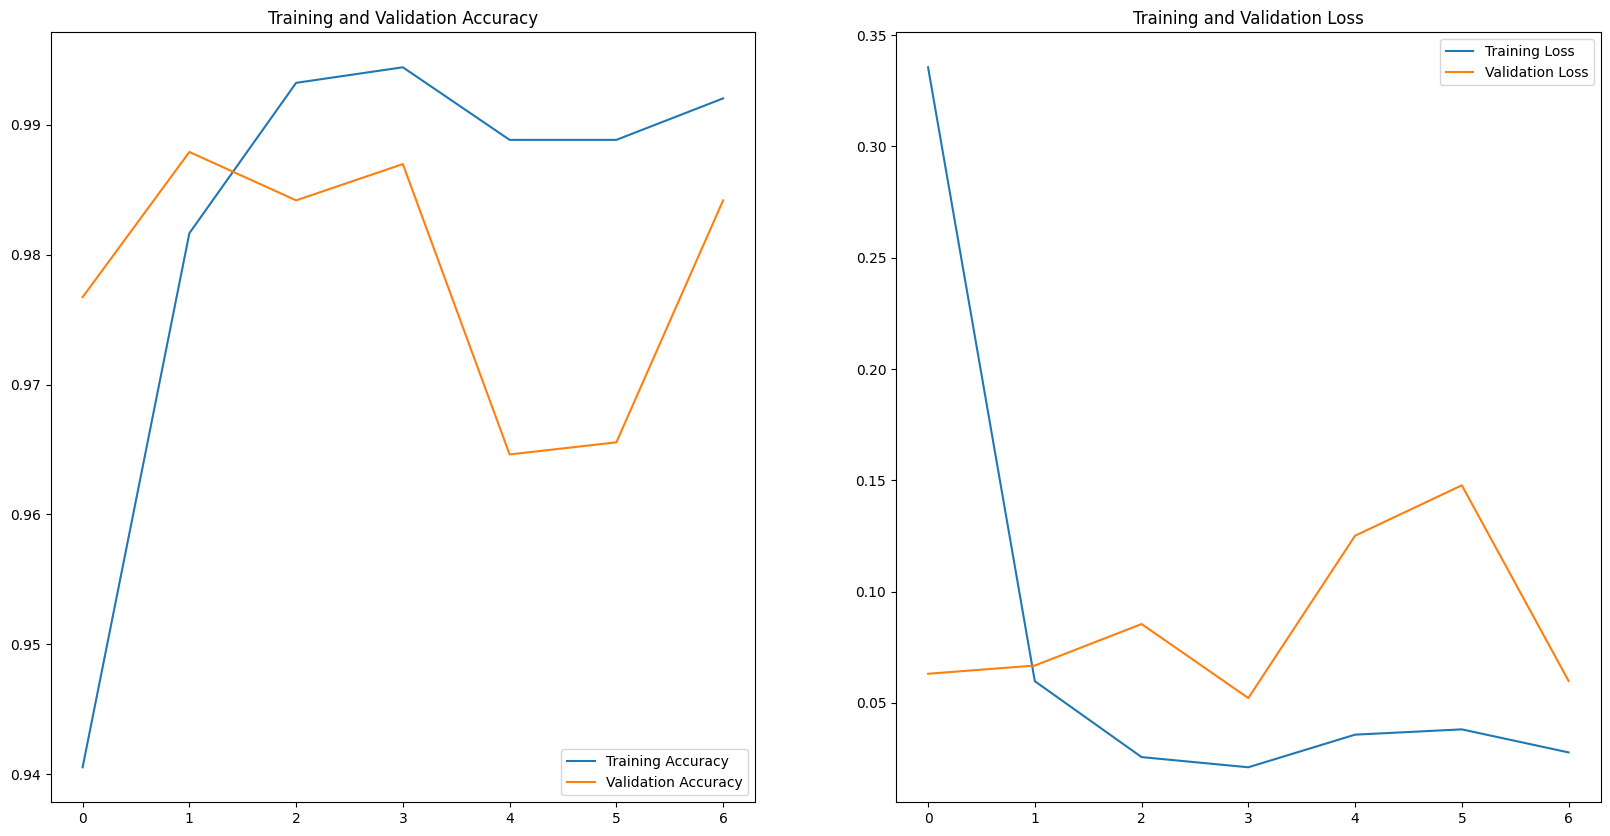

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['val_loss']))
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()